In [2]:
import warnings; warnings.simplefilter('ignore')
import datetime as dat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as wb 
import requests
import zipfile as zi 
import io
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
df = pd.read_csv('/Users/elyes/Desktop/oxfordmanrealizedvolatilityindices copy.csv', index_col=1, header=0 )
rv1 = df['rk_th2']
rv1.index = pd.to_datetime(df.iloc[:,0])
rv1 = pd.DataFrame(rv1)
rv1['Symbol'] = df.index

# We will use SPX

In [4]:
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()

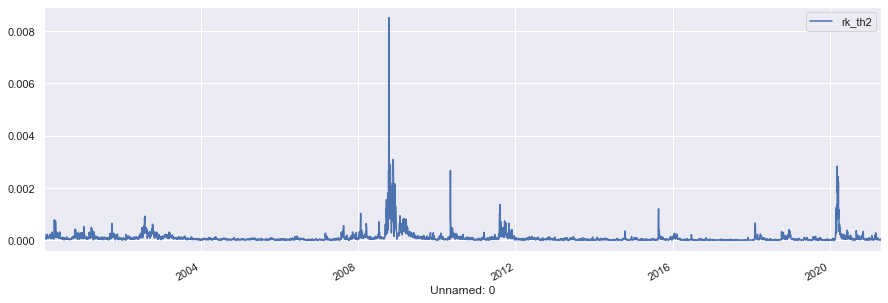

In [5]:
rv1.plot(figsize=(15,5))
plt.show()

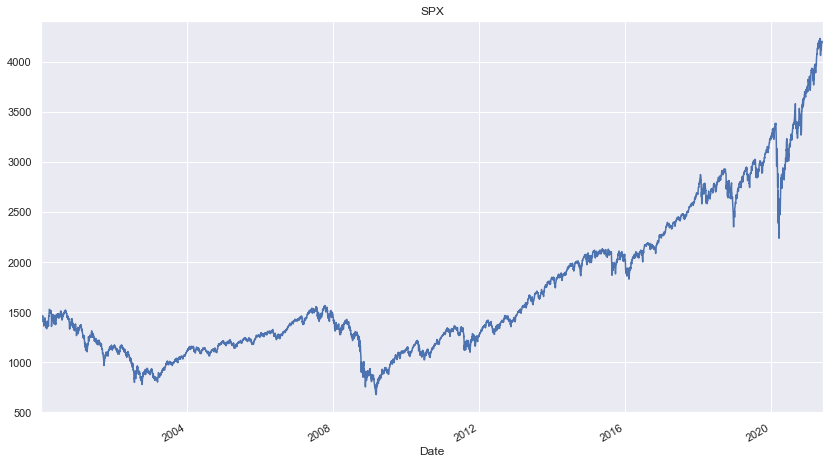

In [6]:
SPX = wb.DataReader(name = '^GSPC',data_source = 'yahoo', start='2000-01-01')
SPX = SPX['Adj Close']
SPX.plot(title='SPX',figsize=(14, 8));

In [7]:
spx = rv1 
spx['sqrt']= np.sqrt(spx['rk_th2'])
spx['log_sqrt'] = np.log(spx['sqrt'])

def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

[0.08397519061943558, 0.16751519336448562, 0.25082211547343863, 0.33409727761003855, 0.5009887333983462]


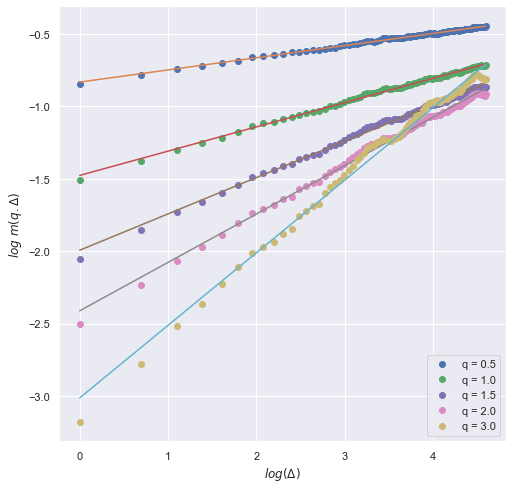

In [8]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o',label = 'q = {}'.format(q)) 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1) 
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    plt.legend()
    
print(zeta_q)

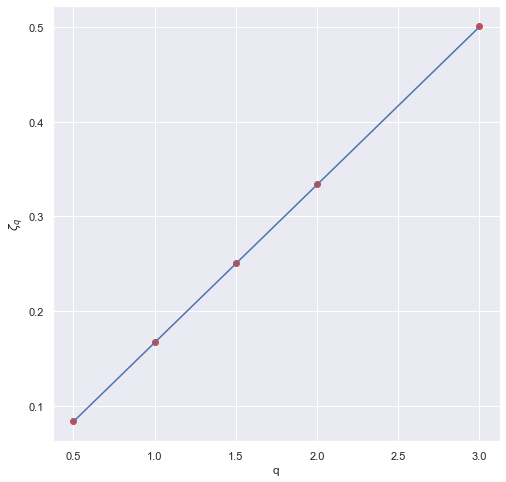

In [9]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec)
h_est= line[0]

In [10]:
def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

In [11]:
sig = rv1['rk_th2']
sig = np.log(np.sqrt(sig))
sig = sig.dropna()
model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
nu = (np.sqrt(np.exp(model[1])))
h = (model[0]/2.)

In [12]:
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(rvdata.truncate(after=date))
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / np.sum(ldata['cf'])
    
    return np.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

In [16]:
df = pd.read_csv('/Users/elyes/Desktop/oxfordmanrealizedvolatilityindices copy.csv', index_col=1, header=0 )
rv1 = df['rk_th2']
rv1.index = pd.to_datetime(df.iloc[:,0])
rv1 = pd.DataFrame(rv1)
rv1['Symbol'] = df.index
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()
rvdata = rv1.drop(['Symbol'],axis = 1)

In [17]:
h = h_est
n = len(rvdata)
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values
rv_actual.reshape(1,len(rv_actual))
rv_predict = np.array(rv_predict)

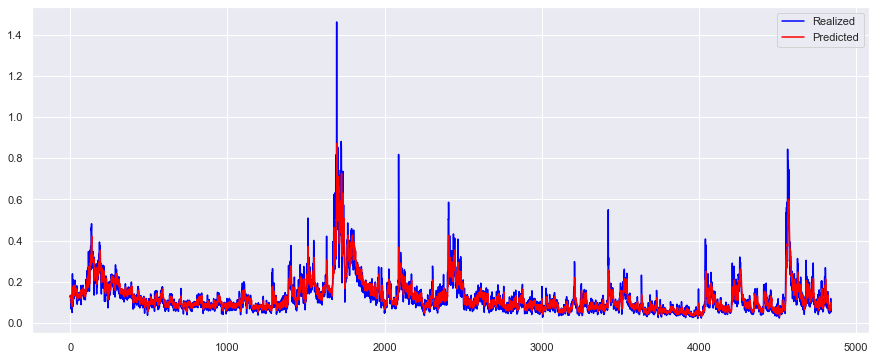

In [18]:
plt.figure(figsize=(15, 6))
vol_actual = np.sqrt(rv_actual * 252 ) 
vol_predict = np.sqrt(rv_predict * 252)
plt.plot(vol_actual,color = "blue",label ='Realized')
plt.plot(vol_predict,color = "red",label ='Predicted')
plt.legend()
plt.show()

# Errors

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=120, figsize=(15,10))
fig.canvas.set_window_title('Rough Volatility')
errors = {}
G = np.linspace(0,1,10)
for i, ax in enumerate(axes.flatten()): 
    rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=G[i]) for d in dates]
    rv_actual = rvdata.iloc[nLags+delta:n].values
    rv_predict = np.array(rv_predict)
    vol_actual = np.sqrt(rv_actual * 252 ) 
    vol_predict = np.sqrt(rv_predict * 252)
    errors['$/nu$ = {}'.format(round(G[i],3))] = np.sum((vol_actual.reshape(1,len(vol_actual))[0]**2 - vol_predict**2)**2)
    ax.plot(vol_actual,color = "blue",label ='Realized')
    ax.plot(vol_predict,color = "red",label ='Predicted')
    ax.set_title('$\nu$ %1.2f'%G[i],fontsize=10)
    

In [16]:
pd.DataFrame(errors.values(),errors.keys()).T

,$/nu$ = 0.0,$/nu$ = 0.111,$/nu$ = 0.222,$/nu$ = 0.333,$/nu$ = 0.444,$/nu$ = 0.556,$/nu$ = 0.667,$/nu$ = 0.778,$/nu$ = 0.889,$/nu$ = 1.0
0,8.154567,8.094989,7.935287,7.743086,7.671825,8.045309,9.538551,13.566197,23.13444,44.761311


# Swap Curve

In [19]:

def xi(date, tt, nu,h, tscale):  # dt=(u-t) is in units of years
    return [forecast_XTS(rvdata,h=h,date=date,nLags=500,delta=dt*tscale,nu=nu) for dt in tt]

h = h_est

def varSwapCurve(date, bigT, nSteps, nu, h, tscale, onFactor):
    # Make vector of fwd variances
    tt = [ float(i) * (bigT) / nSteps for i in range(nSteps+1)]
    delta_t = tt[1]
    xicurve = xi(date, tt, nu, h, tscale)
    xicurve_mid = (np.array(xicurve[0:nSteps]) + np.array(xicurve[1:nSteps+1])) / 2
    xicurve_int = np.cumsum(xicurve_mid) * delta_t
    varcurve1 = np.divide(xicurve_int, np.array(tt[1:]))
    varcurve = np.array([xicurve[0],]+list(varcurve1))
    varcurve = varcurve * onFactor * tscale #  onFactor is to compensate for overnight moves
    res = pd.DataFrame({"texp":np.array(tt), "vsQuote":np.sqrt(varcurve)})
    return res

In [20]:
rv1 = df[['rk_th2']]
rv1.index = pd.to_datetime(df.iloc[:,0])
#rv1 = pd.DataFrame(rv1)
rv1['Symbol'] = df.index
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()
rvdata = rv1.drop(['Symbol'],axis = 1)#pd.DataFrame(rv1['rk_th2'])

In [21]:
from dateutil.tz import tzutc
from scipy.interpolate import interp1d
from matplotlib.mlab import *
def varSwapForecast(date,tau,nu,h,tscale,onFactor,l):
    vsc = varSwapCurve(date, bigT=l, nSteps=int(l * 252), nu=nu, h=h,
                    tscale=tscale, onFactor=onFactor) # Creates the whole curve
    x = vsc['texp']
    y = vsc['vsQuote']
    #f = interp1d(x,y, kind='cubic')
    #x_new = np.linspace(tau.min(), tau.max(), int(l * 252), endpoint=True)
    #res = f(x_new)
    return np.array(x),np.array(y)

# Test the function

tau = np.array([0,.5,1,1.5,2,2.5])
date = dat.datetime(2021,5,20,0,0,tzinfo=tzutc())
x_new,var_swap = varSwapForecast(date,tau,nu=nu,h=h,tscale=252,onFactor=1,l=1)

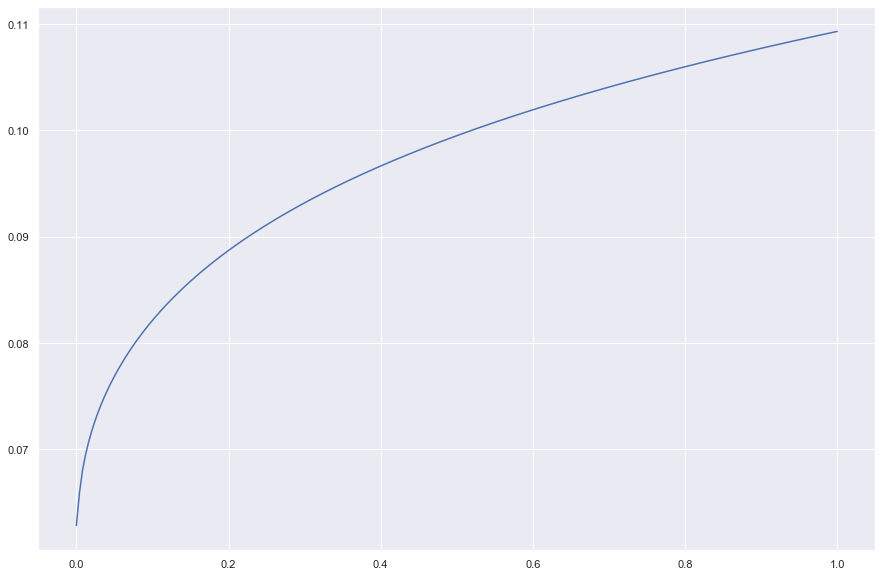

In [22]:
fig = plt.figure(figsize = (15,10))
plt.plot(x_new,var_swap)
plt.show()

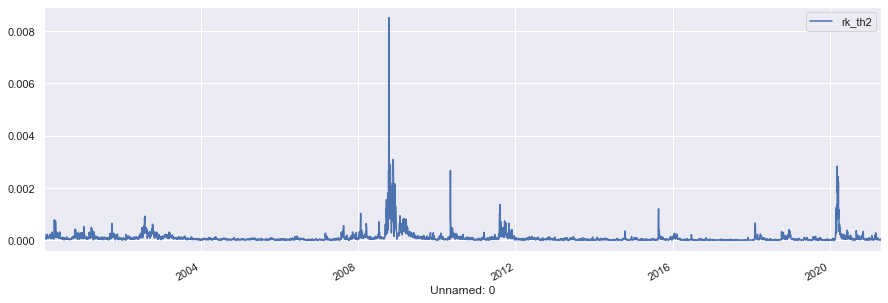

In [23]:
rvdata.plot(figsize=(15,5))

In [24]:


date1 = dat.datetime(2008, 9, 12,tzinfo=tzutc())
date2 = dat.datetime(2008, 9, 15,tzinfo=tzutc())

# Variance curve fV model forecasts
tau1000 = [ float(i) * 2.5 / 1000. for i in range(1,1001)]
vs1 = varSwapForecast(date1, tau1000, nu=nu,h=h, tscale=252, onFactor=1.29,l = 1)
vs2 = varSwapForecast(date2, tau1000, nu=nu,h=h, tscale=252, onFactor=1.29,l = 1)

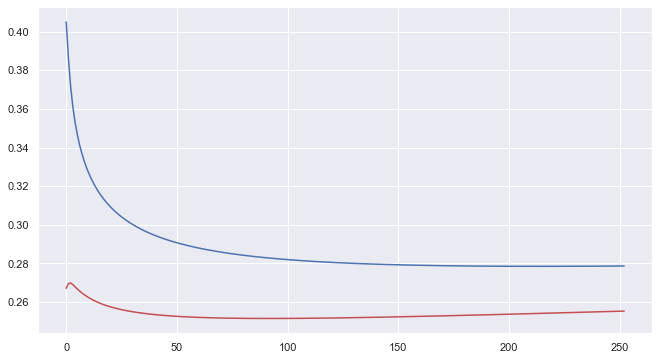

In [25]:
plt.figure(figsize=(11, 6))
plt.plot(vs1[1], "r")
plt.plot(vs2[1], "b")

# Generate Monte Carlo Simulations

In [22]:
import numba 
from numba import jit
from scipy import linalg

In [61]:
%%time
@jit(nopython=True, parallel=True)
def Rough_Bergomi_model(dt,var_swap,strike,spot,rate,N,T,p,e,w_):
    callT = np.zeros(N)
    expiry = T/252 
    for i in numba.prange(N) :
        path = np.zeros(T)
        dW = np.zeros(T)
        path[0] = np.log(spot)
        #e = np.random.normal(0,1,T)
        for j in numba.prange( 1 , T ) :
            #simulate Brownian Motion first
            dW[j] = np.sqrt(dt) * ( p * e[i,j]) + np.sqrt( 1 - p ** 2 ) * (w_[ i , j ] - w_[i , j - 1 ] )
            #Generate Log Normal Paths 
            path[j] = path[j-1] + var_swap[j]*dW[j] - .5 * var_swap[j]**2 * dt
        callT[i] =  np.maximum(np.exp(path[-1]) - strike, 0.0)
    callT = np.mean(callT) * np.exp(-rate * expiry) 
    return callT , dW

CPU times: user 657 µs, sys: 617 µs, total: 1.27 ms
Wall time: 1.82 ms


In [41]:
%%time
@jit(nopython=True, parallel=True,fastmath=True)
def autocov(t1,t2,empty_mt,n,H):
    for m in range(n):
        l = t2[m] 
        for i in range(n): 
            x = t1[i]
            empty_mt[i,m] = .5 * (x**(2*H) + l**(2*H) - np.abs(x-l)**(2*H))
    return empty_mt

CPU times: user 351 µs, sys: 79 µs, total: 430 µs
Wall time: 435 µs


In [119]:
%%time
@jit(nopython=True, parallel=True,fastmath=True)
def Generate_MC(Lower_mt,rnd,M,arr):
    for i in numba.prange(M):
        arr[i,:] = Lower_mt @ rnd[i,:]
    return arr

CPU times: user 457 µs, sys: 907 µs, total: 1.36 ms
Wall time: 2.76 ms


In [120]:
def Data_Prep(N):
    empty_mt = np.zeros(N).reshape(int(np.sqrt(N)),int(np.sqrt(N)))
    t1 = np.linspace(1/252,4,1000)
    t2 = np.linspace(1/252,4,1000)
    df = autocov(t1,t2,empty_mt,len(t2),h)
    Lower_mt = linalg.cholesky( df , lower=True )
    rnd = np.random.normal(size=( N , len(t1) ))
    arr = np.ones(N*len(t1)).reshape(N,len(t1))
    b = Generate_MC(Lower_mt,rnd,N,arr)
    return rnd , b

In [121]:
e,e_ = Data_Prep(int(1e6))

In [130]:
%%time
S0 = 4360.30
N = int(1e6)
P,dW = Rough_Bergomi_model( 1/252 , var_swap , S0 , S0 , 0 , N , len(var_swap) , 1 , rnd , b )
print('Number of iteration : {}'.format( N ) + ' Bergomi Price : ' + str(P) )

Number of iteration : 1000000 Bergomi Price : 169.99506616770705
CPU times: user 3.68 s, sys: 11.3 s, total: 14.9 s
Wall time: 27 s


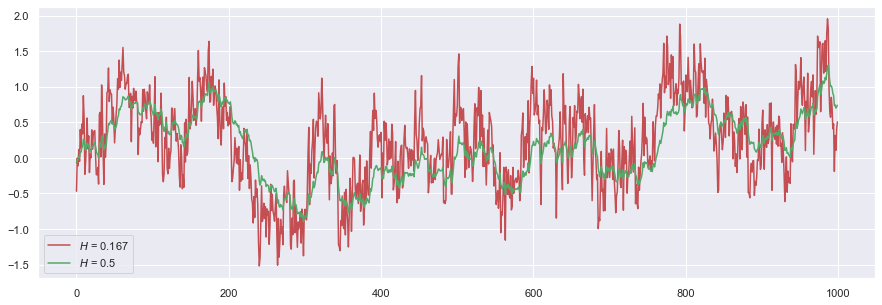

In [129]:
fig = plt.figure(figsize = (15,5))
plt.plot(e_[-100],label = '$H$ = 0.167',color = 'r')
plt.plot(np.cumsum(np.sqrt(1/252)*e[-100]),label = '$H$ = 0.5',color = 'g')
plt.legend()
plt.show()

# Compare with BS Model

In [133]:
%%time

import numpy as np
from scipy import stats, special, integrate

def char_func(x,s,vol,t=1,r=0):
    mean = np.log(s) + (r - 0.5*vol*vol) * t
    var = vol*vol*t
    w = np.exp(1j*x*mean - x*x*var*0.5)
    return w

def call_value(s,k,vol,t=1,r=0):
    
    def integrand(x,s,k,vol,t=1,r=0):
        I = np.exp(-1j*x*np.log(k)) * char_func(x-1j,s,vol,t,r)/((1j * x)*char_func(-1j,s,vol,t,r))
        return I.real

    def integrand2(x,s,k,vol,t=1,r=0):
        I = np.exp(-1j*x*np.log(k)) * char_func(x,s,vol,t,r)/(1j * x)
        return I.real

    int1 = integrate.quad(integrand,0,np.inf,args=(s,k,vol,t,r))
    int1 = 0.50 + int1[0]/(np.pi)

    int2 = integrate.quad(integrand2,0,np.inf,args=(s,k,vol,t,r))
    int2 = 0.50 + int2[0]/(np.pi)
                
    return s*int1 - np.exp(-r*t)*k*int2,int1,int2

CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 20 µs


In [134]:
S0 = 4360.30
print(call_value(S0,S0,0.09908325,1))

(172.2856301383863, 0.519756167022724, 0.48024383297727163)


# Using Cholesky decomposition

In [28]:
from scipy import linalg
import numba 
from numba import jit
empty_mt = np.zeros(1000*1000).reshape(1000,1000)
H = 0.163

In [29]:
t1 = np.linspace(0.001,5,1000)
t2 = np.linspace(0.001,5,1000)

In [30]:
%%time
@jit(nopython=True, parallel=True,fastmath=True)
def autocov(t1,t2,empty_mt,n):
    for m in range(n):
        l = t2[m] 
        for i in range(n): 
            x = t1[i]
            empty_mt[i,m] = .5 * (x**(2*H) + l**(2*H) - np.abs(x-l)**(2*H))
    return empty_mt

CPU times: user 177 µs, sys: 1e+03 ns, total: 178 µs
Wall time: 183 µs


In [31]:
%%time
df = autocov(t1,t2,empty_mt,len(t2))

CPU times: user 302 ms, sys: 14.6 ms, total: 316 ms
Wall time: 328 ms


In [33]:
M = int(1e6)
Lower_mt = linalg.cholesky(df, lower=True)
rnd = np.random.normal(size=(M,len(t1)))
arr = np.ones(M*len(t1)).reshape(M,len(t1))

In [34]:
@jit(nopython=True, parallel=True,fastmath=True)
def Generate_MC(Lower_mt,rnd,M,arr):
    for i in numba.prange(M):
        arr[i,:] = Lower_mt @ rnd[i,:]
    return arr
        

In [35]:
%%time
b = Generate_MC(Lower_mt,rnd,int(1e6),arr)

CPU times: user 11min 28s, sys: 11min 7s, total: 22min 36s
Wall time: 2min 1s


In [ ]:
Lower_mt = linalg.cholesky(df, lower=True)
W_h_t = {} 
for i in range(100):
    W_h_t[i] = np.dot(Lower_mt,np.random.normal(0,1,1000).reshape(1000,1))

# Using Eigenvectors Decomposition (To be continued)

In [426]:
rnd = np.random.normal(size=(100000,len(t1)))

In [428]:
len(rnd)

100000

In [275]:
H = 0.10
def _autocovariance(k):
        """Autocovariance for fgn."""
        return 0.5 * (abs(k - 1) ** (2 * H) - 2 * abs(k) ** (2 * H) + abs(k + 1) ** (2 * H))
row_component = [_autocovariance(i) for i in range(1, 1000)]
reverse_component = list(reversed(row_component))
row = [_autocovariance(0)] + row_component + [0] + reverse_component

In [281]:
eig = np.fft.fft(row).real
ev = np.sqrt(eig)
len(ev)

2000

In [311]:
Z = np.random.normal(0,1,2000).reshape(2000,1)
DFT = np.fft.fft(Z).real
a2 = np.fft.fft(np.dot(ev,DFT))
a1 = eig_vectors * a2 /(len(eig_vectors) + 1)

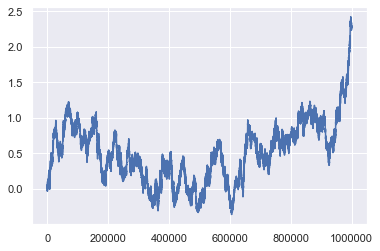

In [312]:
plt.plot((a1.reshape(1,1000000)[0]).real.cumsum())

In [212]:
empty_mt = np.zeros(1000*1000).reshape(1000,1000)
t1 = np.linspace(0,4,1000)
t2 = np.linspace(0,4,1000)
H = 0.99
dt = 4/1000

In [235]:
%%time
for m,l in enumerate(t2):
    empty_mt[:,m] = [.5 * ((np.abs(x-l) + dt)**(2*H) + (2 * np.abs(x-l))**(2*H) + np.abs(abs(x-l) - dt)**(2*H)) for x in t1]

CPU times: user 5.18 s, sys: 14.6 ms, total: 5.19 s
Wall time: 5.22 s


In [236]:
circl = linalg.circulant(empty_mt[:,0])

In [237]:
circl

array([[1.78681168e-05, 4.62589461e+01, 4.61673067e+01, ...,
        4.85511904e-04, 2.27044357e-04, 7.05933179e-05],
       [7.05933179e-05, 1.78681168e-05, 4.62589461e+01, ...,
        8.45062089e-04, 4.85511904e-04, 2.27044357e-04],
       [2.27044357e-04, 7.05933179e-05, 1.78681168e-05, ...,
        1.30508593e-03, 8.45062089e-04, 4.85511904e-04],
       ...,
       [4.60757572e+01, 4.59842977e+01, 4.58929282e+01, ...,
        1.78681168e-05, 4.62589461e+01, 4.61673067e+01],
       [4.61673067e+01, 4.60757572e+01, 4.59842977e+01, ...,
        7.05933179e-05, 1.78681168e-05, 4.62589461e+01],
       [4.62589461e+01, 4.61673067e+01, 4.60757572e+01, ...,
        2.27044357e-04, 7.05933179e-05, 1.78681168e-05]])

In [238]:

eig_values,eig_vectors = linalg.eig(circl)
eig_values

array([ 1.55307606e+04+0.00000000e+00j,  2.29065177e+03+7.39496081e+03j,
        2.29065177e+03-7.39496081e+03j,  5.56555765e+02+3.69132451e+03j,
        5.56555765e+02-3.69132451e+03j,  2.34690546e+02+2.45988213e+03j,
        2.34690546e+02-2.45988213e+03j,  1.21936657e+02+1.84458377e+03j,
        1.21936657e+02-1.84458377e+03j,  6.97222111e+01+1.47550864e+03j,
        6.97222111e+01-1.47550864e+03j,  4.13500249e+01+1.22949087e+03j,
        4.13500249e+01-1.22949087e+03j,  2.42388216e+01+1.05377435e+03j,
        2.42388216e+01-1.05377435e+03j,  1.31312418e+01+9.21989386e+02j,
        1.31312418e+01-9.21989386e+02j,  5.51500111e+00+8.19489153e+02j,
        5.51500111e+00-8.19489153e+02j,  6.66276831e-02+7.37486754e+02j,
        6.66276831e-02-7.37486754e+02j, -3.96486554e+00+6.70391084e+02j,
       -3.96486554e+00-6.70391084e+02j, -7.03134395e+00+6.14475015e+02j,
       -7.03134395e+00-6.14475015e+02j, -9.41791439e+00+5.67158371e+02j,
       -9.41791439e+00-5.67158371e+02j, -1.13116725

In [231]:
ev = abs(eig_values)**(1/2)

In [232]:
Z = np.random.normal(0,1,1000).reshape(1000,1)
DFT = scipy.fft.ifft(Z).real
DFT

array([[ 2.38603821e-01],
       [ 3.61694440e-01],
       [ 1.57834156e+00],
       [-4.74501734e-01],
       [ 5.57702761e-01],
       [ 1.56303047e+00],
       [-1.26849843e+00],
       [ 2.42300940e-01],
       [-6.22229756e-01],
       [-2.39049434e-01],
       [-2.91213367e-01],
       [-8.48198866e-02],
       [ 7.86442101e-01],
       [ 1.10299615e+00],
       [ 1.13712194e-01],
       [-5.85095602e-01],
       [-1.87542787e+00],
       [-2.23355052e-01],
       [-1.17116271e+00],
       [ 7.62306069e-01],
       [ 1.44214966e+00],
       [-3.84251689e-01],
       [-1.09132350e+00],
       [ 1.33655362e+00],
       [-1.16535235e+00],
       [ 2.14775742e-01],
       [-4.09018589e-02],
       [ 1.29347752e+00],
       [-5.74260781e-01],
       [ 5.97509342e-01],
       [ 1.05592999e+00],
       [-8.48904717e-01],
       [ 2.25766183e-01],
       [ 1.77054718e+00],
       [ 6.87202258e-01],
       [ 1.33134993e+00],
       [ 2.15670764e+00],
       [ 6.47881976e-01],
       [ 1.3

In [233]:
a2 = np.fft.fft(np.dot(ev,DFT))
a1 = eig_vectors * a2

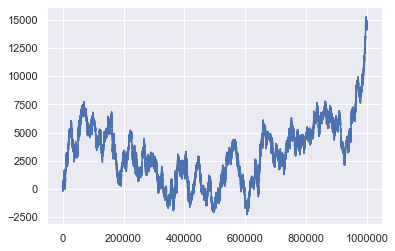

In [234]:
plt.plot(a1.reshape(1,1000000).real[0].cumsum())

In [136]:
a1.reshape(1,1000000).real[0]

array([ 0.00816656,  0.00648417,  0.00648417, ..., -0.00488283,
        0.00609178,  0.00609178])